# Intelligent Customer Support Agent

## Motivation

In today's fast-paced business environment, efficient and accurate customer support is crucial. Automating the initial stages of customer interaction can significantly reduce response times and improve overall customer satisfaction. This project aims to showcase how advanced language models and graph-based workflows can be combined to create a sophisticated support system that can handle a variety of customer inquiries.

## Prerequisites

- Intermediate Python(OOP)

- Langchain(Integrations with third-party apis, Prompt templates, Chains)
- LangGraph(State management)
- MongoDB

## Key Components

1. State Management: Using TypedDict to define and manage the state of each customer interaction.

2. Query Categorization: Classifying customer queries into Technical, Billing, or General categories.
3. Sentiment Analysis: Determining the emotional tone of customer queries.
4. Response Generation: Creating appropriate responses based on the query category.
5. Escalation Mechanism: Automatically escalating queries with negative sentiment to human agents.
6. Workflow Graph: Utilizing LangGraph to create a flexible and extensible workflow.

## Method Details

1. Initialization: Set up the environment and import necessary libraries.

2. State Definition: Create a structure to hold query information, category, sentiment, and response.
3. Node Functions: Implement functions for categorization, sentiment analysis, and response generation.
4. Graph Construction: Use StateGraph to define the workflow, adding nodes and edges to represent the support process.
5. Conditional Routing: Implement logic to route queries based on their category and sentiment.
6. Workflow Compilation: Compile the graph into an executable application.
7. Execution: Process customer queries through the workflow and retrieve results.


## Libraries


In [32]:
from typing_extensions import TypedDict
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from pydantic import BaseModel

## Load environmental variables


In [24]:
from dotenv import load_dotenv

load_dotenv()

True

## Model

We will be using **Groq** for llm inference.

Be sure to have a `GROQ_API_KEY` in your environment variable.

You can create a groq api key by visiting <https://groq.com/>.

In [5]:
llm = ChatGroq(model="qwen-2.5-32b", temperature=0)

## Define State Structure

State structure holds the query, category, sentiment and response for each customer interaction.


In [6]:
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

## Define Response Structure for Sentiment and Category analysis

The response structure holds the sentiment and category of the query. It is used to extract structured output from the llm call.


In [7]:
class QueryDetails(BaseModel):
    sentiment: str
    category: str

## Define Node Functions

These functions represent the different stages of processing a customer query.


In [ ]:
def get_sentiment_and_category(state: State):
    """Get the sentiment and category of the query."""

    # The system prompt can be customized depending on desired sentiments and categories
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "Analyze the sentiment and category of the following customer query.\
             For sentiment, respond only with either Positive, Neutral or Negative.\
                 For category, respond only with either General, Billing or Technical",
            ),
            ("user", "Query: {query}"),
        ]
    )

    # Get the structured response from the llm
    chain = prompt | llm.with_structured_output(QueryDetails)

    response = chain.invoke({"query": state["query"]})

    return {"sentiment": response.sentiment, "category": response.category}


def route_query_from_sentiment(state: State):
    """Routing logic based on sentiment."""
    sentiment = state["sentiment"]

    # Route to escalate node if sentiment is Negative, else proceed with further operations
    match sentiment:
        case "Negative":
            return "escalate"
        case _:
            return "handle_queries"


def escalate(state: State):
    """Escalates a query to a representative."""
    return {
        "response": "This query has been escalated to a customer service representative due to its negative sentiment."
    }


def handle_queries(state: State):
    """Generate response for a query."""
    prompt = f"Generate a {state['category']} support response for the following query: \"{state['query']}\" , under 50 words."

    response = llm.invoke(prompt).content

    return {"response": response}

The record_to_database function utilizes a mongodb database to store the result.

Be sure to have a `MONGO_URL` in your environment variable.

You can obtain a key by visiting <https://www.mongodb.com/>.

Learn how to use mongodb with python from <https://www.w3schools.com/python/python_mongodb_getstarted.asp>.

In [ ]:
import pymongo
import os

def record_to_database(state: State):
    """Records the final state of the graph to a MongoDB database."""
    try:
        client = pymongo.MongoClient(os.environ["MONGO_URL"])
        database = client["customer_service_database"]
        collection = database["customer_service"]
        payload = state

        x = collection.insert_one(payload)
        print(f"Inserted document ID: {x.inserted_id}")
    except Exception as e:
        print("An error occurred: ", e)

## Define the graph


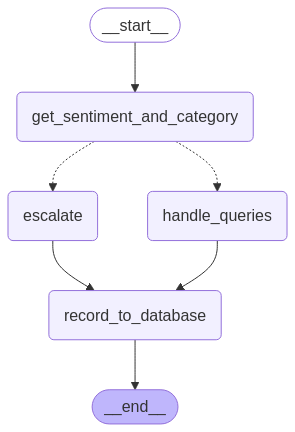

In [ ]:
builder = StateGraph(State)

# Add Nodes
builder.add_node("get_sentiment_and_category", get_sentiment_and_category)
builder.add_node("escalate", escalate)
builder.add_node("handle_queries", handle_queries)
builder.add_node("record_to_database", record_to_database)

# Add edges
builder.add_edge(START, "get_sentiment_and_category")
builder.add_conditional_edges(
    "get_sentiment_and_category",
    route_query_from_sentiment,
    ["escalate", "handle_queries"],
)
builder.add_edge("handle_queries", "record_to_database")
builder.add_edge("escalate", "record_to_database")
builder.add_edge("record_to_database", END)

# Compile
graph = builder.compile()

# Visualize
display(Image(graph.get_graph().draw_mermaid_png()))

## Testing the customer support agent


In [33]:
def run_agent(query: str):
    """Function to run the agent once a query arrives."""
    # Invoke the graph and get the response
    result = graph.invoke({"query": query})
    
    # Print the query and result
    print("Query: ", query)
    print("Sentiment: ", result["sentiment"])
    print("Category: ", result["category"])
    print("Response: ", result["response"])
    print("-x-x-x-x-x-x-x-x-")

In [34]:
queries = [
    "So, how many days are needed to install after i confirm my booking.",
    "The delivery experience of my recent package was pretty bad. I was not expecting that.",
    "How much do i have to pay if i book my trip one month earlier, is there any discounts?",
    "What are your business hours?",
]


for query in queries:
    run_agent(query)

Inserted document ID: 67ece141cbd07acc4db059d5
Query:  So, how many days are needed to install after i confirm my booking.
Sentiment:  Neutral
Category:  Technical
Response:  Thank you for your inquiry. The installation process typically takes 3-5 business days after your booking confirmation. We will keep you updated throughout the process.
-x-x-x-x-x-x-x-x-
Inserted document ID: 67ece143cbd07acc4db059d7
Query:  The delivery experience of my recent package was pretty bad. I was not expecting that.
Sentiment:  Negative
Category:  General
Response:  This query has been escalated to a customer service representative due to its negative sentiment.
-x-x-x-x-x-x-x-x-
Inserted document ID: 67ece14acbd07acc4db059d9
Query:  How much do i have to pay if i book my trip one month earlier, is there any discounts?
Sentiment:  Neutral
Category:  Billing
Response:  Thank you for your inquiry. Booking your trip one month in advance may qualify you for early booking discounts. The exact discount varies

## Conclusion

By combining natural language processing capabilities with a structured graph-based approach, we've created a customer support agent that can efficiently handle a wide range of queries. This system can be further extended and customized to meet specific business needs, potentially integrating with existing customer support tools and databases for even more sophisticated interactions.
